## **PUBMED Dataset Preprocessing**

Imports

In [7]:
from src.training_utils import *
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print(transformers.__version__)

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: difra00 (deepl_wizards). Use `wandb login --relogin` to force relogin


4.30.2


Load the Pubmed dataset which was downloaded to the local directory 

In [8]:
pubmed_dataset = load_dataset("ccdv/pubmed-summarization")
print(pubmed_dataset)

No config specified, defaulting to: pubmed-summarization/section
Found cached dataset pubmed-summarization (/home/peppe/.cache/huggingface/datasets/ccdv___pubmed-summarization/section/1.0.0/f765ec606c790e8c5694b226814a13f1974ba4ea98280989edaffb152ded5e2b)
100%|██████████| 3/3 [00:00<00:00, 761.91it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6658
    })
})


Load and Visualize the Dataset, cleaning two examples in the validation

In [9]:
import json
from tqdm import tqdm

def load_corpus(fname, is_training):
    corpus = []
    with open(fname, "r") as f:
        lines = f.readlines()  # Read all lines into a list
        for i, line in tqdm(enumerate(lines), total=len(lines)):
            data = json.loads(line)
            if len(data["text"]) == 0 or len(data["summary"]) == 0:
                print(i)
                continue
            if is_training:
                if len(data["indices"]) == 0 or len(data["score"]) == 0:
                    continue

            corpus.append(data)
    return corpus

val = load_corpus("src/data/PubMed/test_PUBMED.jsonl", False)
train = load_corpus("src/data/PubMed/train_PUBMED_labelled.jsonl", True)


100%|██████████| 116937/116937 [00:05<00:00, 22099.65it/s]


In [4]:
pubmed_dataset['validation'][2320]

{'article': ' \n  \n  \n  \n ',
 'abstract': "according to the central limit theorem , the means of a random sample of size , n , from a population with mean ,  , and variance , 2 , distribute normally with mean ,  , and variance , 2n . using the central limit theorem , \n a variety of parametric tests have been developed under assumptions about the parameters that determine the population probability distribution . \n compared to non - parametric tests , which do not require any assumptions about the population probability distribution , parametric tests produce more accurate and precise estimates with higher statistical powers . \n however , many medical researchers use parametric tests to present their data without knowledge of the contribution of the central limit theorem to the development of such tests . \n thus , this review presents the basic concepts of the central limit theorem and its role in binomial distributions and the student 's t - test , and provides an example of the

In [5]:
pubmed_dataset['validation'][4923]

{'article': ' \n  \n  \n  \n  \n ',
 'abstract': 'highlightswe present a rare case of a congenital splenic cyst that corresponds to less than 10% of non - parasitic splenic cyst.we describe our laparoscopic approach management of a partial splenectomywe review the literature on the different treatment options for npsc based on recurrence and success rates .'}

## **Clean Dataset Class**

In [10]:
from torch.utils.data import Dataset

class Clean_Dataset(Dataset):
    # This is used to clean the noisy sample from PubMed train
    def __init__(self, abs_dataset, ext_dataset, val = False):
        self.abs_dataset = abs_dataset
        self.ext_dataset = ext_dataset
        self.abs_dataset, self.ext_dataset = self.preprocess(val)


    def __len__(self):
        return len(self.ext_dataset)
    
    def __getitem__(self, idx):

        return self.abs_dataset[idx], self.ext_dataset[idx]
    
    def compare(self,s1,s2, red = True):
        distance = (s1[:len(s2)+10].strip()).startswith(s2.strip())#Levenshtein.distance(s1[:100], s2[:100])
        if not distance:
            if red:
                print(f"\nEXT: \n", s2)
                print(f"\nABS: \n", s1[:len(s2)+10])
            return False
        else:
            return True
            
    
    def preprocess(self, val = False):
        new_dataset_abs = []
        new_dataset = []
        new_ext = []
        count = 0
        for idx in tqdm(range(len(self.abs_dataset))):

            if self.abs_dataset[idx]['article'] != "":
                if not val:
                    new_dataset_abs.append({"article": self.abs_dataset[idx]['article'], 'abstract': self.abs_dataset[idx]['abstract']})
                elif val and idx not in [4923, 2320]:
                    new_dataset_abs.append({"article": self.abs_dataset[idx]['article'], 'abstract': self.abs_dataset[idx]['abstract']})

            else:
                count+=1
        if not val:
            for idx in range(len(self.ext_dataset)):
                if self.compare(new_dataset_abs[idx]['article'],self.ext_dataset[idx]['text'][0]):
                    new_dataset.append({"article": new_dataset_abs[idx]['article'], 'abstract': new_dataset_abs[idx]['abstract']})
                    new_ext.append(self.ext_dataset[idx])
                    continue
                    
                else:
                    count+=1
                    for idx2 in range(1, len(new_dataset_abs[idx:])):
                        if self.compare(new_dataset_abs[idx2+idx]['article'],self.ext_dataset[idx]['text'][0], red = False):
                            new_dataset.append({"article": new_dataset_abs[idx2+idx]['article'], 'abstract': new_dataset_abs[idx2+idx]['abstract']})
                            new_ext.append(self.ext_dataset[idx])
                            break
        else:
            new_dataset = new_dataset_abs
            new_ext = self.ext_dataset

        return new_dataset, new_ext
        

Run only once

In [11]:
# train_new = Clean_Dataset(pubmed_dataset['train'], train, val = False)
# val_new = Clean_Dataset(pubmed_dataset['test'], val, val = True)
# print(len(train_new))
# print(len(val_new))

100%|██████████| 6658/6658 [00:00<00:00, 13149.12it/s]

6658


In [16]:
# serialized_data_val = [sample for sample in val_new]
#serialized_data_train = [sample for sample in val_new]

In [17]:
#with open("src/data/PubMed/Train_ExtAbs_PUBMED.json", "w") as f:
#    json.dump(serialized_data_train, f)

# with open("src/data/PubMed/Test_ExtAbs_PUBMED.json", "w") as f:
#    json.dump(serialized_data_val, f)

Load the saved dataset by opening the .json file

In [3]:
with open("src/data/PubMed/Train_ExtAbs_PUBMED.json") as f:
        training_corpus = json.load(f)

In [4]:
len(training_corpus) # len is 113754 # Removed the sentences that were not in the abstractive, and grouped them correctly.

113754

In [11]:
#Visualize an example
training_corpus[0][1]

{'text': ['a recent systematic analysis showed that in 2011 , 314 ( 296 - 331 ) million children younger than 5 years were mildly , moderately or severely stunted and 258 ( 240 - 274 ) million were mildly , moderately or severely underweight in the developing countries .',
  'in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2% , 8.6% and 1.5% , for underweight , overweight and obesity , respectively .',
  'the prevalence of malnutrition among elementary school aged children in tehran varied from 6% to 16% .',
  'anthropometric study of elementary school students in shiraz revealed that 16% of them suffer from malnutrition and low body weight .',
  'snack should have 300 - 400 kcal energy and could provide 5 - 10 g of protein / day . nowadays , school nutrition programs are running as the national programs , world - wide . national school lunch program in the united states',
  'there are also some reports regarding school feeding programs in 

In [6]:
with open("src/data/PubMed/Val_ExtAbs_PUBMED.json") as f:
        validation_corpus = json.load(f)
len(validation_corpus) # len is 6631 # removed the same sentences of the original

6631

In [13]:
#Visualize an example
validation_corpus[0][1]

{'summary': ['background and aim : there is lack of substantial indian data on venous thromboembolism ( vte ) .',
  'the aim of this study was to provide real - world information on patient characteristics , management strategies , clinical outcomes , and temporal trends in vte.subjects and methods : multicentre retrospective registry involving 549 medical records of patients with confirmed diagnosis of vte ( deep vein thrombosis [ dvt ] confirmed by doppler ultrasonography ; pulmonary embolism [ pe ] by computed tomography , pulmonary angiography and/or v / q scan ) from 2006 to 2010 at three indian tertiary care hospitals.results:acute dvt without pe , acute dvt with pe , and pe alone were reported in 64% ( 352/549 ) , 23% ( 124/549 ) , and 13% ( 73/549 ) patients , respectively .',
  'mean age was 47 ( 16 ) years , and 70% were males .',
  'h / o dvt ( 34% ) , surgery including orthopedic surgery ( 28% ) , trauma ( 16% ) , and immobilization > 3 days ( 14% ) were the most common ris

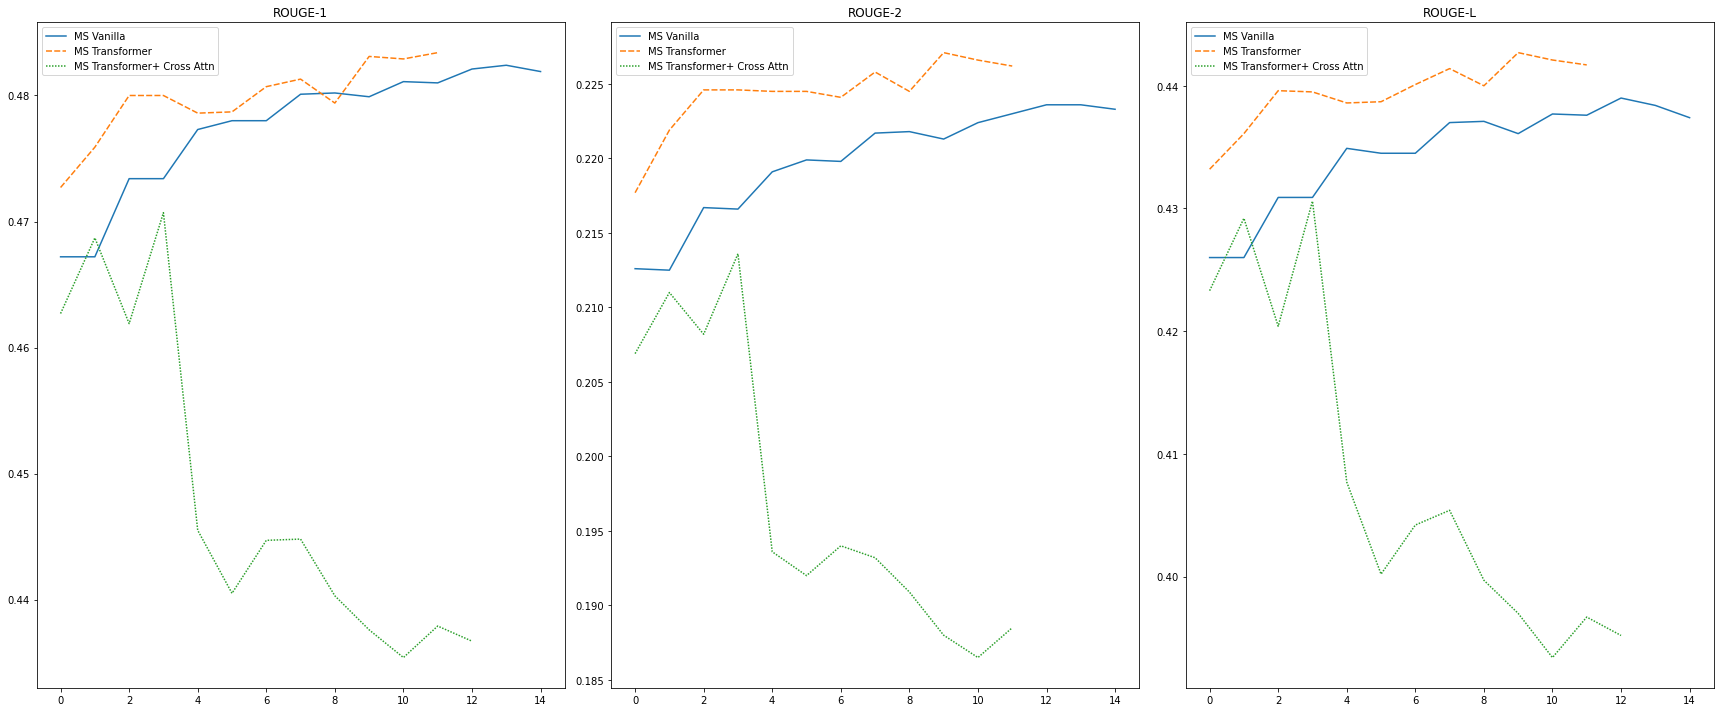

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data for ROUGE-1, ROUGE-2, and ROUGE-L
rouge1_memsum = [0.4672, 0.4672, 0.4734, 0.4734, 0.4773, 0.4780, 0.4780, 0.4801, 0.4802, 0.4799, 0.4811, 0.4810, 0.4821, 0.4824, 0.4819]
rouge2_memsum = [0.2126, 0.2125, 0.2167, 0.2166, 0.2191, 0.2199, 0.2198, 0.2217, 0.2218, 0.2213, 0.2224, 0.2230, 0.2236, 0.2236, 0.2233]
rougeL_memsum = [0.4260, 0.4260, 0.4309, 0.4309, 0.4349, 0.4345, 0.4345, 0.4370, 0.4371, 0.4361, 0.4377, 0.4376, 0.4390, 0.4384, 0.4374]

rouge1_transformer = [0.4727, 0.4759, 0.4800, 0.4800, 0.4786, 0.4787, 0.4807, 0.4813, 0.4794, 0.4831, 0.4829, 0.4834]
rouge2_transformer = [0.2177, 0.2219, 0.2246, 0.2246, 0.2245, 0.2245, 0.2241, 0.2258, 0.2245, 0.2271, 0.2266, 0.2262]
rougeL_transformer = [0.4332, 0.4361, 0.4396, 0.4395, 0.4386, 0.4387, 0.4401, 0.4414, 0.4400, 0.4427, 0.4421, 0.4417]

rouge1_transformer_cross = [0.4627, 0.4687, 0.4619, 0.4707, 0.4455, 0.4405, 0.4447, 0.4448, 0.4403, 0.4376, 0.4354, 0.4379, 0.4367]
rouge2_transformer_cross = [0.2069, 0.2110, 0.2082, 0.2136, 0.1936, 0.192, 0.194, 0.1932, 0.1909, 0.1880, 0.1865, 0.1885]
rougeL_transformer_cross = [0.4233, 0.4292, 0.4204, 0.4306, 0.4077, 0.4002, 0.4042, 0.4054, 0.3997, 0.3970, 0.3934, 0.3967, 0.3952]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 10))  # Adjust the figsize as needed

# ROUGE-1
sns.lineplot(data=[rouge1_memsum, rouge1_transformer, rouge1_transformer_cross], ax=axes[0])
axes[0].set_title("ROUGE-1")
axes[0].legend(['MS Vanilla', 'MS Transformer', 'MS Transformer+ Cross Attn'])

# ROUGE-2
sns.lineplot(data=[rouge2_memsum, rouge2_transformer, rouge2_transformer_cross], ax=axes[1])
axes[1].set_title("ROUGE-2")
axes[1].legend(['MS Vanilla', 'MS Transformer', 'MS Transformer+ Cross Attn'])

# ROUGE-L
sns.lineplot(data=[rougeL_memsum, rougeL_transformer, rougeL_transformer_cross], ax=axes[2])
axes[2].set_title("ROUGE-L")
axes[2].legend(['MS Vanilla', 'MS Transformer', 'MS Transformer+ Cross Attn'])

# Adjust layout
plt.tight_layout()
plt.savefig("rouge_results.pdf")
# Display the plot
plt.show()
